# IMPORT LIBRARIES

In [1]:
import os
import pickle

import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop, Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from IPython.core.pylabtools import figsize

## LOAD DATA(FEATURES_2)

In [7]:
Y_data = np.loadtxt(path+file_labels, delimiter=',', skiprows=1, usecols=range(1,3))


dir_list_ = os.listdir("/tmp/elias/emotion_recognition/data")
dir_list_.sort()
count = 0
dir_list = []
dir_list_.pop(0)

for i in range(20):
    dir_list.append(dir_list_[i])
PPG_data = []

for file in dir_list:
    dat_file = '/tmp/elias/emotion_recognition/data/' + file
    with open(dat_file, 'rb') as f:
        Channel_data =pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for num_video in range(40):
        dataP = data[num_video,38]
        PPG_data.append(dataP[384:])



4800 4800


In [ ]:
        
        
# time step
# window = 6
# window = 240

count = 0
train_data = []
label=[]

# # There's something wrong in label
# for PPG in X_data:
#     for i in range(window,len(X_data)+window):
#         label.append(Y_data[count])
#         train_data.append(X_data[i-window:i])
#     count += 1
    
seq_length = 1280
dataX=[]
dataY=[]
# seq_length = 240
for i in range(0, int(len(X_data)/seq_length)):
   _x = X_data[(i*seq_length):(i*seq_length) + seq_length]
   dataX.append(_x)
   _y = Y_data[(i*seq_length) + seq_length-1]
   dataY.append(_y)
    
train_data = dataX
label = dataY

In [8]:
x=train_data[0]
print(len(train_data),len(x),len(x[0]))
# for i in range(5000):
#     k = labels_Vdata[i]
#     if k[1] < 1:
#         print(k)
#     else:
#         print("d")

800 6 12


## ASSIGN GPU memory

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-02-11 15:41:59.411757: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-02-11 15:41:59.458757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-02-11 15:41:59.459013: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-02-11 15:41:59.461152: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-02-11 15:41:59.462845: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-02-11 15:41:59.463164: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu

## Reshape AND Normalize

In [11]:
# import warnings
# warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

x_train_data = np.array(train_data)
y_train_data = np.array(label)
print(np.array(train_data).shape , y_train_data.shape)

# normalize data
Train_nsamples, Train_nx, Train_ny = x_train_data.shape
train_dataset = x_train_data.reshape((Train_nsamples,Train_nx*Train_ny))
scaler = MinMaxScaler(feature_range=(-1, 1)) ##
x_train_data = scaler.fit_transform(train_dataset)

###
X_train = x_train_data.reshape((Train_nsamples, Train_nx, Train_ny))
Y_train = y_train_data.reshape((y_train_data.shape[0], 2))

print(X_train.shape)
print(Y_train.shape)

(800, 6, 12) (800, 2)
(800, 6, 12)
(800, 2)


# Build model

  ## - Hypyer Parameters

In [12]:
# Set Hyperparameters of the model
learning_rate = 0.001
epochs = 200
batch_size=64

  ## - Stack hidden Layers to the GRU model

In [13]:
model = Sequential()
model.add(GRU(units=128,
              dropout=0.25,
              recurrent_dropout=0.25,
              return_sequences=False,
              input_shape=X_train[0].shape))

# Dense net
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))

# Save highest accuracy
callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='BinaryClassification_Dense3-callback.h5', monitor='val_accuracy', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=120)]

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128)               54528     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [15]:
history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=callback_list,
                    verbose=1)

Train on 640 samples, validate on 160 samples
Epoch 1/200
 64/640 [==>...........................] - ETA: 15s - loss: 0.6915 - accuracy: 0.5234

2022-02-11 15:44:13.933699: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


640/640 [==============================] - 2s 3ms/sample - loss: 0.6942 - accuracy: 0.5375 - val_loss: 0.6649 - val_accuracy: 0.6500
Epoch 2/200
640/640 [==============================] - 0s 283us/sample - loss: 0.6919 - accuracy: 0.5281 - val_loss: 0.6769 - val_accuracy: 0.6531
Epoch 3/200
640/640 [==============================] - 0s 197us/sample - loss: 0.6904 - accuracy: 0.5555 - val_loss: 0.6679 - val_accuracy: 0.6500
Epoch 4/200
640/640 [==============================] - 0s 215us/sample - loss: 0.6894 - accuracy: 0.5562 - val_loss: 0.6726 - val_accuracy: 0.6500
Epoch 5/200
640/640 [==============================] - 0s 223us/sample - loss: 0.6876 - accuracy: 0.5406 - val_loss: 0.6796 - val_accuracy: 0.6531
Epoch 6/200
640/640 [==============================] - 0s 204us/sample - loss: 0.6889 - accuracy: 0.5391 - val_loss: 0.6800 - val_accuracy: 0.6531
Epoch 7/200
640/640 [==============================] - 0s 217us/sample - loss: 0.6885 - accuracy: 0.5531 - val_loss: 0.6805 - val_ac

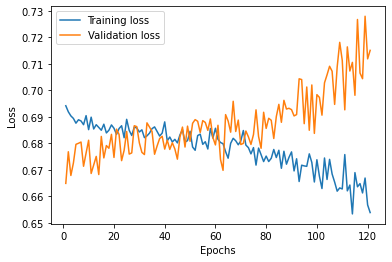

<Figure size 432x288 with 0 Axes>

In [18]:
epoch = np.arange(1,121+1)
plt.plot(epoch, history.history['loss'], label='Training loss')
plt.plot(epoch, history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('BinaryClassification_Dense2_withfeat2-Loss')

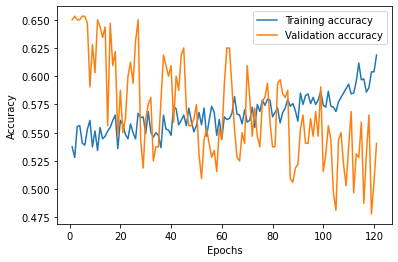

<Figure size 432x288 with 0 Axes>

In [19]:
epoch = np.arange(1,121+1)
plt.plot(epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('BinaryClassification_Dense2_withfeat2-Accuracy')

In [20]:
model.save('BinaryClassification_Dense2_withfeat2.h5')